In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
from network import NeuralNetwork


In [2]:
iris = load_iris()
train_x, test_x, train_y, test_y = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=42)
train_y = np.eye(3)[train_y]
test_y = np.eye(3)[test_y]

mnist_train = pd.read_csv('./data/mnist/mnist_train.csv', header=None)
mnist_test = pd.read_csv('./data/mnist/mnist_test.csv', header=None)

fashion_mnist_train = pd.read_csv('./data/fashion_mnist/fashion_mnist_train.csv', header=None, skiprows=1)
fashion_mnist_test = pd.read_csv('./data/fashion_mnist/fashion_mnist_test.csv', header=None, skiprows=1)

In [3]:
def render_mnist(data, predicted, true_number, amount_correct, amount_false, is_fashion=False):
  fashion_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  correct_indices = np.where(predicted == true_number)[0]
  false_indices = np.where(predicted != true_number)[0]

  fig, axes = plt.subplots(1, amount_correct, figsize=(15, 3))
  for idx, ax in zip(correct_indices[:amount_correct], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    if is_fashion:
      ax.set_title(f"predicted: {fashion_list[predicted[idx]]}/ {fashion_list[true_number[idx]]}", fontsize=11)
    else:
      ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Predictions')
  plt.show()

  fig, axes = plt.subplots(1, amount_false, figsize=(15, 3))
  for idx, ax in zip(false_indices[:amount_false], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    if is_fashion:
      ax.set_title(f"y_hat: {fashion_list[predicted[idx]]}/ {fashion_list[true_number[idx]]}", fontsize=11)
    else:
      ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Incorrect Predictions')
  plt.show()


  

# IRIS dataset

input size: 4, hidden size: 7, output size: 3
Epoch: 1/3000, Loss: 1.0383548471340664, Accuracy: 32.5
Epoch: 2/3000, Loss: 0.826529361865833, Accuracy: 33.33333333333333
Epoch: 3/3000, Loss: 0.6665725988814117, Accuracy: 95.83333333333334
Epoch: 4/3000, Loss: 0.4793945992231527, Accuracy: 96.66666666666667
Epoch: 5/3000, Loss: 0.3714149437673599, Accuracy: 96.66666666666667
Epoch: 6/3000, Loss: 0.3380379883723167, Accuracy: 93.33333333333333
Epoch: 7/3000, Loss: 0.2970830895984597, Accuracy: 95.0
Epoch: 8/3000, Loss: 0.28529703063682377, Accuracy: 94.16666666666667
Epoch: 9/3000, Loss: 0.2676351884940424, Accuracy: 94.16666666666667
Epoch: 10/3000, Loss: 0.26763097463820296, Accuracy: 91.66666666666666
Epoch: 11/3000, Loss: 0.23627071069764488, Accuracy: 94.16666666666667
Epoch: 12/3000, Loss: 0.27017117476304936, Accuracy: 88.33333333333333
Epoch: 13/3000, Loss: 0.2149376601646803, Accuracy: 95.0
Epoch: 14/3000, Loss: 0.19045179994630596, Accuracy: 96.66666666666667
Epoch: 15/3000, Lo

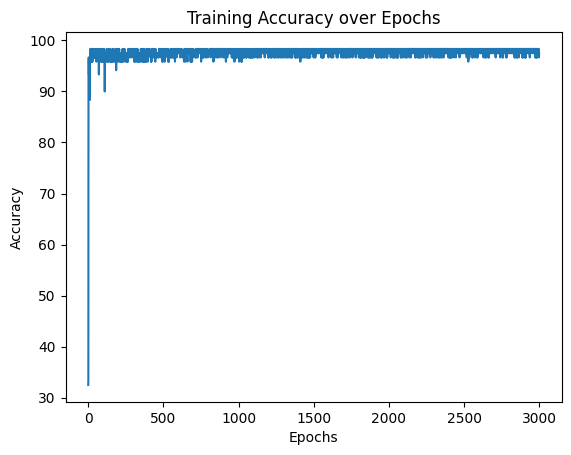

Average Training Accuracy: 97.50% ± 0.00%
Average Testing Accuracy: 100.00% ± 0.00%


In [4]:
input_size = len(iris['data'][0])
output_size = len(np.unique(iris['target']))
hidden_size = 7
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 3000
learning_rate = 0.0001

train_accuracies = []
test_accuracies = []

for i in range(1):
  loss, accuracy = network.train_mbgd(train_x, train_y, epochs, learning_rate, 5)
  train_accuracies.append(accuracy[-1])
  test_accuracy, _, _ = network.evaluate(test_x, test_y)
  test_accuracies.append(test_accuracy)
  if i == 0:
    plt.plot(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.show()

avg_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}% ± {std_train_accuracy:.2f}%")
print(f"Average Testing Accuracy: {avg_test_accuracy:.2f}% ± {std_test_accuracy:.2f}%")

# MNIST dataset

input size: 784, hidden size: 392, output size: 10
Epoch: 1/10, Loss: 0.1326713304090927, Accuracy: 96.06833333333333
Epoch: 2/10, Loss: 0.14447882883465232, Accuracy: 96.16
Epoch: 3/10, Loss: 0.09071934480646116, Accuracy: 97.41499999999999
Epoch: 4/10, Loss: 0.07484648395840982, Accuracy: 97.75
Epoch: 5/10, Loss: 0.08126009786971027, Accuracy: 97.68
Epoch: 6/10, Loss: 0.061139032871857776, Accuracy: 98.20166666666667
Epoch: 7/10, Loss: 0.05602546759724586, Accuracy: 98.43499999999999
Epoch: 8/10, Loss: 0.06189059070254366, Accuracy: 98.505
Epoch: 9/10, Loss: 0.07105578189790658, Accuracy: 98.16833333333334
Epoch: 10/10, Loss: 0.0595895338445478, Accuracy: 98.355
Test accuracy in % 96.69


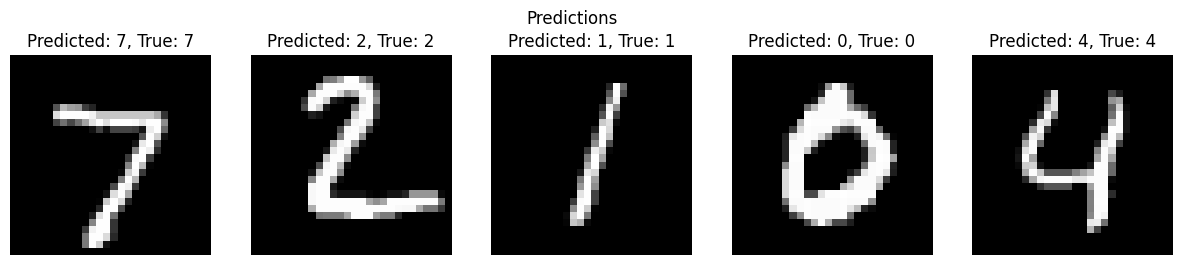

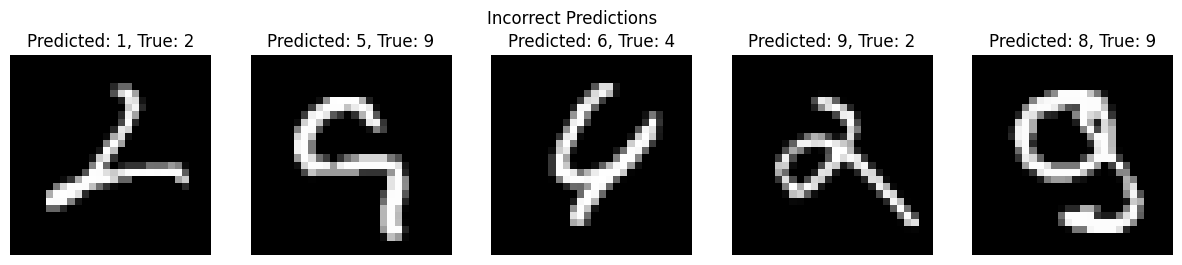

In [5]:
mnist_train_x = mnist_train.iloc[:, 1:].values / 255
mnist_train_y = np.eye(10)[mnist_train.iloc[:, 0].values]
mnist_test_x = mnist_test.iloc[:, 1:].values / 255
mnist_test_y = np.eye(10)[mnist_test.iloc[:, 0].values]

input_size = len(mnist_train_x[0])
output_size = len(np.unique(mnist_train.iloc[:, 0].values))
hidden_size = input_size // 2
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 10
learning_rate = 0.01

loss, accuracy = network.train_mbgd(mnist_train_x, mnist_train_y, epochs, learning_rate, 64)
test_accuracy, predicted_class, true_class = network.evaluate(mnist_test_x, mnist_test_y)

print(f"Test accuracy in % {test_accuracy}")
render_mnist(mnist_test_x, predicted_class, true_class, 5, 5)

# fashion MNIST dataset

input size: 784, hidden size: 392, output size: 10
Test accuracy in % 90.24


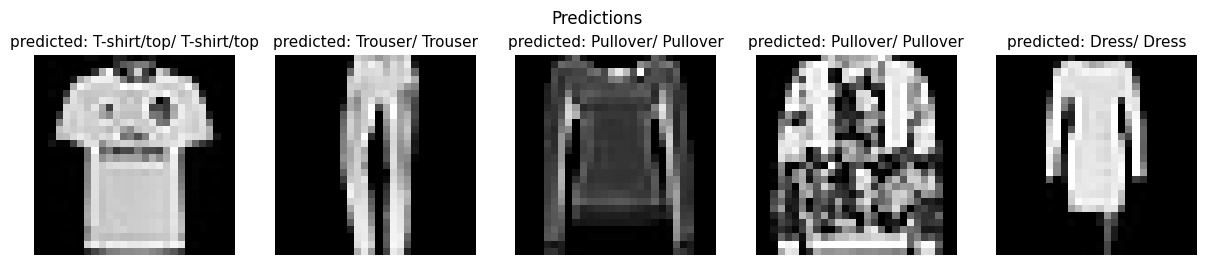

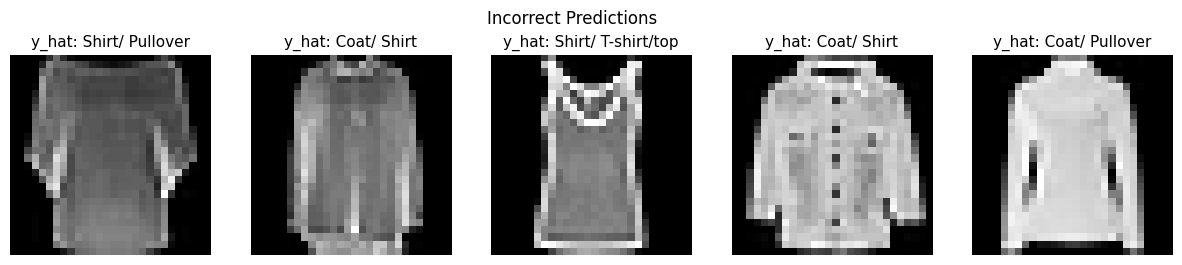

In [67]:
fashion_mnist_train_x = fashion_mnist_train.iloc[:, 1:].values / 255
fashion_mnist_train_y = np.eye(10)[fashion_mnist_train.iloc[:, 0].values]
fashion_mnist_test_x = fashion_mnist_test.iloc[:, 1:].values / 255
fashion_mnist_test_y = np.eye(10)[fashion_mnist_test.iloc[:, 0].values]

input_size = len(fashion_mnist_train_x[0])
output_size = len(np.unique(fashion_mnist_train.iloc[:, 0].values))
hidden_size = input_size // 2
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 30
learning_rate = 0.001

loss, accuracy = network.train_mbgd(fashion_mnist_train_x, fashion_mnist_train_y, epochs, learning_rate, 64)
test_accuracy, predicted_class, true_class = network.evaluate(fashion_mnist_test_x, fashion_mnist_test_y)

print(f"Test accuracy in % {test_accuracy}")
render_mnist(fashion_mnist_test_x, predicted_class, true_class, 5, 5, True)


